<a href="https://colab.research.google.com/github/carbotton/tdl_tarea_1/blob/eda_preproc_data-aug/Tarea_1_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [ ]:
!pip install torchinfo

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    evaluate,
    model_calassification_report,
    show_tensor_image,
    show_tensor_images,
    plot_taining,
    EarlyStopping,
    print_log,
)

In [2]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [4]:
BATCH_SIZE = 128  # tamaño del batch

# Exploracion de datos

El EDA es uno solo, la gracia seria hacerlo con el dataset sin transforms

## Carga de datos

In [5]:
DATA_DIR = Path("data")

# cargamos train y lo dividimos en train y val
imagenette_full_train = datasets.Imagenette(
    DATA_DIR, split="train", download=True
)

train_size = int(0.8 * len(imagenette_full_train))
val_size = len(imagenette_full_train) - train_size

imagenette_train_dataset, imagenette_val_dataset = random_split(
    imagenette_full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # para reproducibilidad
)

# val dataset -> lo usamos como test
imagenette_test_dataset = datasets.Imagenette(
    DATA_DIR, split="val", download=False
)

In [6]:
name_classes = imagenette_full_train.classes # no puedo usar imagenette_train_dataset.classes porque es un subset (surge de haber hecho el random split, no tengo mas atributos de clase ahi
nclasses = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


## Numero de clases y cantidad de imagenes por clase

Todas tienen cantidades similares de imágenes.

Entre la clase que menos tiene y la que más, hay una diferencia de 135 imagenes.

In [7]:
root_dir = "data/imagenette2/train"
classes = os.listdir(root_dir)

class_counts = {}
for cls in classes:
    n_images = len(os.listdir(os.path.join(root_dir, cls)))
    class_counts[cls] = n_images
    print(f"{cls}: {n_images} imágenes")

# Encontrar la clase con menos y más imágenes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print(f"\nClase con MENOS imágenes: {min_class} ({class_counts[min_class]} imágenes)")
print(f"Clase con MÁS imágenes:  {max_class} ({class_counts[max_class]} imágenes)")
print(f"\nLa clase {max_class} tiene {((class_counts[max_class]-class_counts[min_class])/class_counts[max_class])*100:.1f}% más de imágenes que la clase {min_class}")


n03425413: 931 imágenes
n01440764: 963 imágenes
n02979186: 993 imágenes
n03888257: 960 imágenes
n03000684: 858 imágenes
n03445777: 951 imágenes
n02102040: 955 imágenes
n03028079: 941 imágenes
n03394916: 956 imágenes
n03417042: 961 imágenes

Clase con MENOS imágenes: n03000684 (858 imágenes)
Clase con MÁS imágenes:  n02979186 (993 imágenes)

La clase n02979186 tiene 13.6% más de imágenes que la clase n03000684


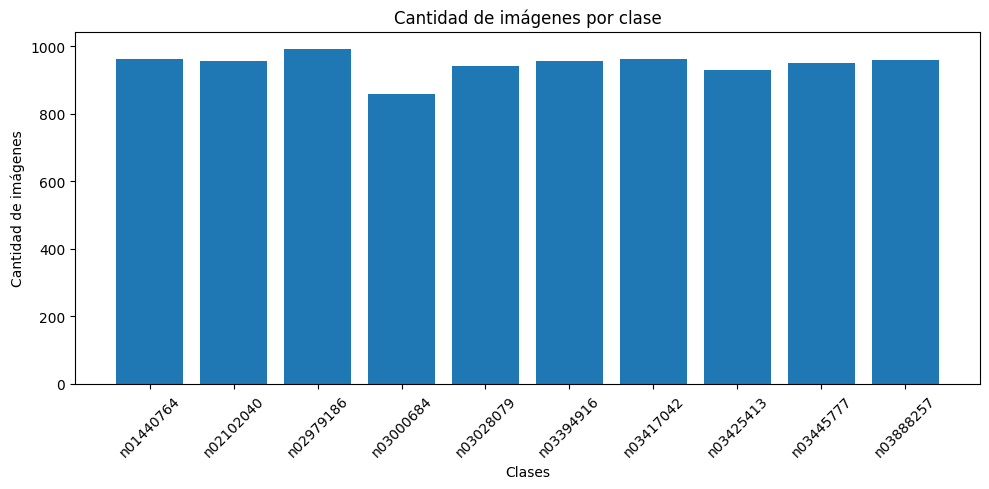

In [8]:
import matplotlib.pyplot as plt

# Ordenar clases para que el gráfico quede prolijo
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Cantidad de imágenes por clase")
plt.tight_layout()
plt.show()


## Ver selección random de imágenes

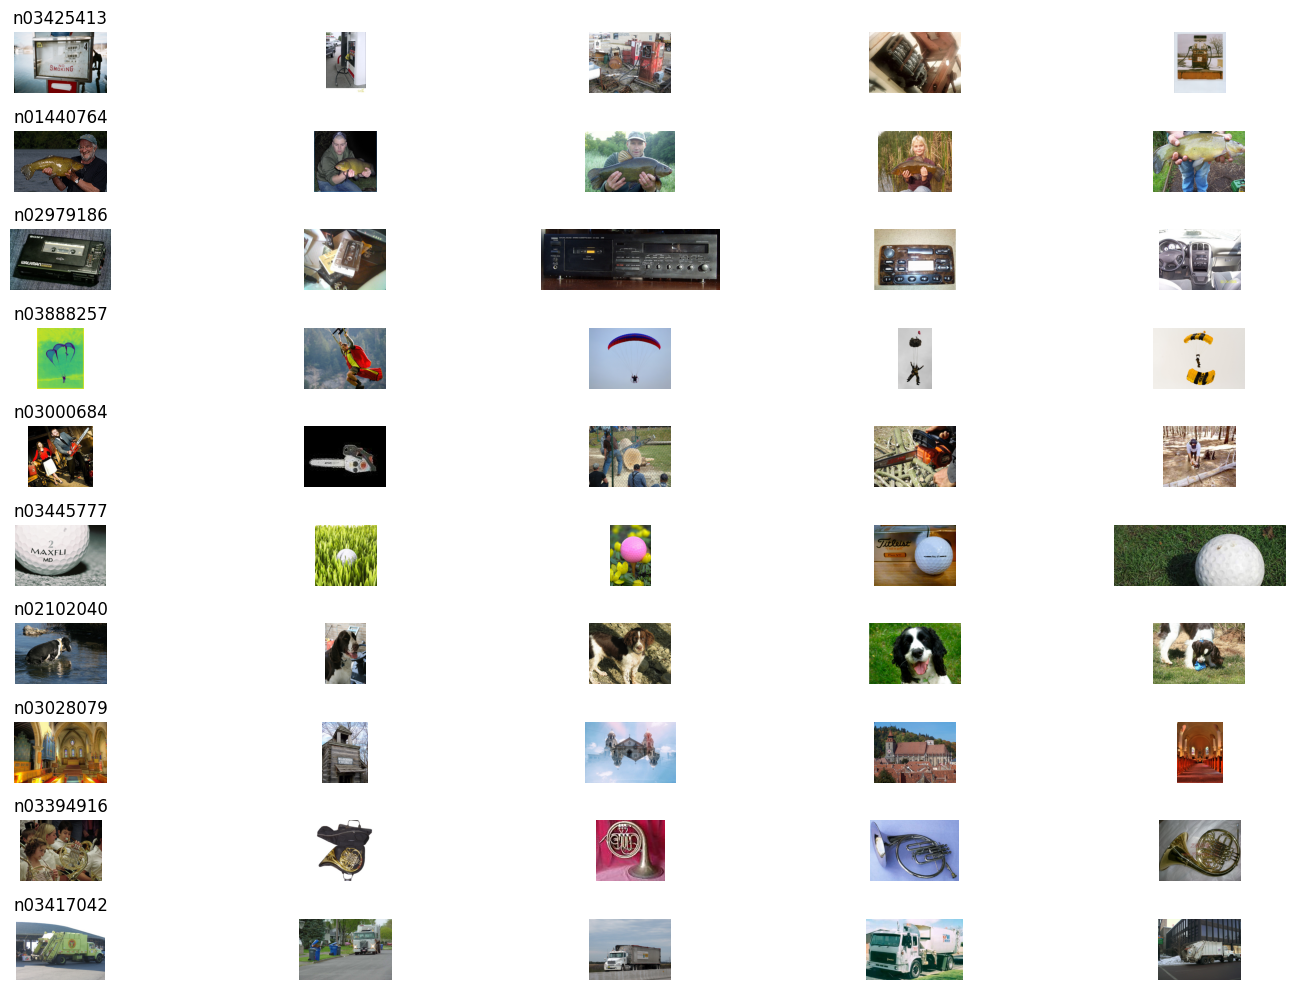

In [9]:
import random
import matplotlib.image as mpimg

n_samples = 5
fig, axs = plt.subplots(len(classes), n_samples, figsize=(15, 10))

for i, cls in enumerate(classes):
    img_files = os.listdir(os.path.join(root_dir, cls))
    for j in range(n_samples):
        img_path = os.path.join(root_dir, cls, random.choice(img_files))
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(cls)
plt.tight_layout()
plt.show()


## Ver tamaños de imágenes

Se puede observar que el tamaño de las imágenes difiere mucho entre una y otra.

In [10]:
from PIL import Image

sizes = []
for cls in classes:
    img_files = os.listdir(os.path.join(root_dir, cls))
    for img_file in img_files[:50]:  # muestra
        img_path = os.path.join(root_dir, cls, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (ancho, alto)

size_counts = {}
for size in sizes:
    if size not in size_counts:
        size_counts[size] = 0
    size_counts[size] += 1

# Encontrar el tamaño más y menos común
most_common_size = None
most_common_count = -1
least_common_size = None
least_common_count = float('inf')

for size, count in size_counts.items():
    if count > most_common_count:
        most_common_size = size
        most_common_count = count
    if count < least_common_count:
        least_common_size = size
        least_common_count = count

print(f"Tamaño de las imágenes: {sizes}")
print(f"\nTotal de tamaños diferentes encontrados: {len(size_counts)}")
print(f"Tamaño MÁS común: {most_common_size} (aparece {most_common_count} veces)")
print(f"Tamaño MENOS común: {least_common_size} (aparece {least_common_count} veces)")


Tamaño de las imágenes: [(470, 500), (375, 500), (500, 375), (300, 500), (500, 375), (400, 500), (367, 500), (400, 836), (500, 375), (375, 500), (250, 237), (500, 375), (364, 500), (375, 500), (512, 800), (500, 375), (500, 377), (375, 500), (400, 533), (413, 310), (375, 500), (500, 375), (500, 332), (500, 375), (375, 500), (500, 375), (375, 500), (375, 500), (500, 375), (400, 500), (600, 502), (500, 375), (500, 400), (500, 375), (375, 500), (1944, 2592), (500, 375), (500, 500), (500, 375), (678, 435), (167, 500), (375, 500), (500, 377), (375, 500), (500, 336), (500, 375), (375, 500), (500, 653), (344, 599), (500, 375), (280, 320), (383, 575), (275, 225), (599, 465), (275, 206), (223, 146), (320, 256), (500, 375), (500, 381), (580, 523), (400, 300), (500, 332), (500, 412), (333, 500), (432, 324), (400, 300), (328, 250), (400, 300), (500, 331), (400, 300), (500, 375), (500, 375), (400, 284), (500, 375), (512, 384), (369, 276), (500, 377), (500, 375), (500, 333), (1024, 768), (334, 250), 

## Buscar duplicados

In [11]:
import hashlib

def md5(fname):
    with open(fname, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []
for cls in classes:
    for img_file in os.listdir(os.path.join(root_dir, cls)):
        path = os.path.join(root_dir, cls, img_file)
        h = md5(path)
        if h in hashes:
            duplicates.append(path)
        else:
            hashes[h] = path
print(f"Encontradas {len(duplicates)} imágenes duplicadas.")


Encontradas 0 imágenes duplicadas.


# LeNet

## Carga de datos con transforms para LeNet

**Transforms:**

Preprocessing -> train y val/test

Data augmentation -> solo train

In [58]:
DATA_DIR = Path("data")

# Wrapper para aplicar transformaciones
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return self.transform(image), label

def get_dataloaders(
    train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - train_transf: transformaciones para el dataset de entrenaiento
    - test_transf: transformaciones para el dataset de test
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    # descargamos el dataset CIFAR10 (si no lo tenemos ya)
    train_dataset = datasets.Imagenette(
        DATA_DIR, split="train", download=True, transform=None
    ) 
    test_dataset = datasets.Imagenette(
        DATA_DIR, split="val", download=False, transform=test_transf
    )

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    # aplicamos las transformaciones
    train_dataset = TransformDataset(train_dataset, train_transf)
    validation_dataset = TransformDataset(validation_dataset, test_transf)

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader

In [37]:
train_tfms_lenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    #T.Normalize(mean=T_MEAN, std=T_STD),
    # AUGMENTATION SOLO EN TRAIN 
    # T.RandomAffine(degrees=10, translate=(0.05,0.05), scale=(0.95,1.05)),
    # T.RandomHorizontalFlip(p=0.5),
    # PREPROCESS:
    T.Resize((32, 32)),
    T.Grayscale(num_output_channels=1),
])

val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.Resize((32, 32)),
    T.Grayscale(num_output_channels=1),
    T.ToDtype(torch.float32, scale=True),
    # T.Normalize(mean=(0.5,), std=(0.5,)),
])


## Regularization

Para saber si necesitamos dropout, entrenar una vez y ver si hay overfitting (val_acc=85% agregar ; val_acc=78% no hace falta)

### Data Augmentation
SOLO PARA TRAINING !!!!!!!!!

### Early stopping

Aplicado en training loop

### Dropout

Aplicado en training loop

## Arquitectura del modelo

In [38]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_dropout=False, dropout_p=0.5):
        """
        LeNet clasica con opción de dropout
        """
        
        super(LeNet, self).__init__()

        self.use_dropout = use_dropout
        self.dropout_p = dropout_p
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(120, 84)
        self.output = nn.Linear(84, num_classes)
        self.flatten = nn.Flatten(start_dim=1)

        self.dropout = nn.Dropout(p=self.dropout_p) if self.use_dropout else nn.Identity()


    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.pool(x)
        x = self.tanh(self.conv2(x))
        x = self.pool(x)
        x = self.tanh(self.conv3(x))
        x = self.flatten(x)
        x = self.tanh(self.linear(x))
        x = self.dropout(x) # despues de la activacion
        x = self.output(x)
        return x


summary(LeNet(1, 10), input_size=(BATCH_SIZE, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [128, 10]                 --
├─Conv2d: 1-1                            [128, 6, 28, 28]          156
├─Tanh: 1-2                              [128, 6, 28, 28]          --
├─AvgPool2d: 1-3                         [128, 6, 14, 14]          --
├─Conv2d: 1-4                            [128, 16, 10, 10]         2,416
├─Tanh: 1-5                              [128, 16, 10, 10]         --
├─AvgPool2d: 1-6                         [128, 16, 5, 5]           --
├─Conv2d: 1-7                            [128, 120, 1, 1]          48,120
├─Tanh: 1-8                              [128, 120, 1, 1]          --
├─Flatten: 1-9                           [128, 120]                --
├─Linear: 1-10                           [128, 84]                 10,164
├─Tanh: 1-11                             [128, 84]                 --
├─Identity: 1-12                         [128, 84]                 --
├─L

## Entrenamiento


In [46]:
LR = 0.001
EPOCHS = 100

letnet_model = LeNet(1,10).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

"""epoch_train_errors, epoch_val_errors = train(
    letnet_model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    DEVICE,
    do_early_stopping=True,
    patience=10,
    epochs=EPOCHS,
    log_fn=print_log,
    log_every=1,
)"""

'epoch_train_errors, epoch_val_errors = train(\n    letnet_model,\n    optimizer,\n    criterion,\n    train_loader,\n    val_loader,\n    DEVICE,\n    do_early_stopping=True,\n    patience=10,\n    epochs=EPOCHS,\n    log_fn=print_log,\n    log_every=1,\n)'

In [47]:
#plot_taining(epoch_train_errors, epoch_val_errors)

In [48]:
#model_calassification_report(letnet_model, val_loader, DEVICE, nclasses)

## Weight & Biases

In [49]:
import wandb

WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "Tarea1_LeNet_2"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tarea_1_letra.ipynb"

wandb.login()

True

In [50]:
sweep_config = {
    "name": "tarea_1_lenet",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},  # o "val_accuracy"
    "parameters": {
        # Optimizador y LR
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4]},

        # Regularización en FC
        "dropout_p": {"values": [0.0, 0.2, 0.3]},

        # Data
        "batch_size": {"values": [64, 128, 256]},

        # Early stopping
        "early_stop": {"values": [True, False]},
        "patience": {"values": [3, 5]},   

        # Entrenamiento                
        "label_smoothing": {"values": [0.0, 0.05]},
        "seed": {"values": [7, 13]},
    },
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: 2ff0um8y
Sweep URL: https://wandb.ai/mc-ort/Tarea1_LeNet_2/sweeps/2ff0um8y


In [51]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


In [59]:
import time 

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    print("[RUN] init", flush=True)
    wandb.init()

    print(f"[RUN] device = {DEVICE}", flush=True)
    
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_dropout_p = config.dropout_p
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing

    # modelo
    if run_dropout_p == 0:
        model = LeNet(1,10).to(DEVICE)
    else:
        model = LeNet(1,10,True,run_dropout_p).to(DEVICE)

    # TODO: aca si tiene dropout tengo que volver a armar la red y ponerle las capaz de dropout que quiera, no se hace solo

    # dataloaders  
    train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=run_weight_decay)
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate, momentum=0.9, nesterov=True, weight_decay=run_weight_decay)

    # criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})
        print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)        

    print("[RUN] starting train...", flush=True)
    train(model, optimizer, criterion, train_loader, val_loader, device=DEVICE, do_early_stopping=run_early_stopping, patience=run_patience,
          epochs=EPOCHS, log_fn=log_with_timing, log_every=1)
    
    # guardo pesos temporalmente
    torch.save(model.state_dict(), "model.pth")
    wandb.save(f"model.pth")

    wandb.finish()

In [53]:
print("DEVICE = ", DEVICE)

DEVICE =  cuda


In [54]:
wandb.agent(sweep_id, function=sweep_run, count=10) # corre sweep_run 10 veces

wandb: Agent Starting Run: e89rsmfa with config:
wandb: 	batch_size: 256
wandb: 	dropout_p: 0.3
wandb: 	early_stop: False
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0040667665682077815
wandb: 	optimizer: adam
wandb: 	patience: 5
wandb: 	seed: 13
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] device = cuda
[RUN] starting train...
[EPOCH 1] train_loss=2.1848 val_loss=2.0939
[EPOCH 2] train_loss=2.1277 val_loss=2.0888
[EPOCH 3] train_loss=2.0991 val_loss=2.0589
[EPOCH 4] train_loss=2.0856 val_loss=2.0700
[EPOCH 5] train_loss=2.0753 val_loss=2.0528
[EPOCH 6] train_loss=2.0680 val_loss=2.0322
[EPOCH 7] train_loss=2.0592 val_loss=2.0835
[EPOCH 8] train_loss=2.0551 val_loss=2.0307
[EPOCH 9] train_loss=2.0469 val_loss=2.0140
[EPOCH 10] train_loss=2.0213 val_loss=2.0371
[EPOCH 11] train_loss=2.0248 val_loss=2.0113
[EPOCH 12] train_loss=2.0030 val_loss=2.0275
[EPOCH 13] train_loss=1.9785 val_loss=2.0013
[EPOCH 14] train_loss=1.9796 val_loss=2.0042
[EPOCH 15] train_loss=1.9547 val_loss=1.9799
[EPOCH 16] train_loss=1.9281 val_loss=1.9918
[EPOCH 17] train_loss=1.9169 val_loss=1.9948
[EPOCH 18] train_loss=1.8885 val_loss=1.9775
[EPOCH 19] train_loss=1.8664 val_loss=1.9813
[EPOCH 20] train_loss=1.8410 val_loss=2.0161
[EPOCH 21] train_loss=1.8259 val_loss=1.9950
[EPOCH 22] train_los

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██████▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▄▅▆▆▇▆▇▇▇███████████▇
epoch,100
train_loss,0.47322
val_loss,3.16891


wandb: Agent Starting Run: sp4il45l with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.00033447956313788663
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 7
wandb: 	weight_decay: 0


[RUN] init


[RUN] device = cuda
[RUN] starting train...
[EPOCH 1] train_loss=2.3045 val_loss=2.3020
[EPOCH 2] train_loss=2.3037 val_loss=2.3010
[EPOCH 3] train_loss=2.3033 val_loss=2.3001
[EPOCH 4] train_loss=2.3015 val_loss=2.2994
[EPOCH 5] train_loss=2.3016 val_loss=2.2986
[EPOCH 6] train_loss=2.3004 val_loss=2.2980
[EPOCH 7] train_loss=2.3002 val_loss=2.2974
[EPOCH 8] train_loss=2.2995 val_loss=2.2968
[EPOCH 9] train_loss=2.2984 val_loss=2.2962
[EPOCH 10] train_loss=2.2983 val_loss=2.2956
[EPOCH 11] train_loss=2.2971 val_loss=2.2951
[EPOCH 12] train_loss=2.2964 val_loss=2.2946
[EPOCH 13] train_loss=2.2962 val_loss=2.2940
[EPOCH 14] train_loss=2.2960 val_loss=2.2935
[EPOCH 15] train_loss=2.2949 val_loss=2.2930
[EPOCH 16] train_loss=2.2951 val_loss=2.2925
[EPOCH 17] train_loss=2.2940 val_loss=2.2920
[EPOCH 18] train_loss=2.2935 val_loss=2.2915
[EPOCH 19] train_loss=2.2929 val_loss=2.2909
[EPOCH 20] train_loss=2.2921 val_loss=2.2904
[EPOCH 21] train_loss=2.2920 val_loss=2.2898
[EPOCH 22] train_los

epoch,▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train_loss,███████▇▇▇▇▇▇▇▇▇▆▆▆▆▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,█████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁
epoch,100
train_loss,2.14912
val_loss,2.1365


wandb: Agent Starting Run: fhv09u58 with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0001974738834607032
wandb: 	optimizer: adam
wandb: 	patience: 3
wandb: 	seed: 7
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] device = cuda
[RUN] starting train...
[EPOCH 1] train_loss=2.2834 val_loss=2.2495
[EPOCH 2] train_loss=2.2086 val_loss=2.1509
[EPOCH 3] train_loss=2.1419 val_loss=2.1078
[EPOCH 4] train_loss=2.1205 val_loss=2.0942
[EPOCH 5] train_loss=2.1061 val_loss=2.0840
[EPOCH 6] train_loss=2.0987 val_loss=2.0761
[EPOCH 7] train_loss=2.0912 val_loss=2.0725
[EPOCH 8] train_loss=2.0848 val_loss=2.0661
[EPOCH 9] train_loss=2.0813 val_loss=2.0621
[EPOCH 10] train_loss=2.0759 val_loss=2.0622
[EPOCH 11] train_loss=2.0695 val_loss=2.0574
[EPOCH 12] train_loss=2.0650 val_loss=2.0546
[EPOCH 13] train_loss=2.0612 val_loss=2.0501
[EPOCH 14] train_loss=2.0577 val_loss=2.0440
[EPOCH 15] train_loss=2.0539 val_loss=2.0427
[EPOCH 16] train_loss=2.0473 val_loss=2.0403
[EPOCH 17] train_loss=2.0445 val_loss=2.0389
[EPOCH 18] train_loss=2.0418 val_loss=2.0348
[EPOCH 19] train_loss=2.0364 val_loss=2.0283
[EPOCH 20] train_loss=2.0305 val_loss=2.0215
[EPOCH 21] train_loss=2.0254 val_loss=2.0197
[EPOCH 22] train_los

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
train_loss,█▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_loss,██▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂
epoch,100
train_loss,1.5815
val_loss,1.86889


wandb: Agent Starting Run: ntg7ox7a with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0005078170254421623
wandb: 	optimizer: sgd
wandb: 	patience: 5
wandb: 	seed: 7
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] device = cuda
[RUN] starting train...
[EPOCH 1] train_loss=2.3034 val_loss=2.3032
[EPOCH 2] train_loss=2.3028 val_loss=2.3028
[EPOCH 3] train_loss=2.3024 val_loss=2.3024
[EPOCH 4] train_loss=2.3027 val_loss=2.3020
[EPOCH 5] train_loss=2.3019 val_loss=2.3016
[EPOCH 6] train_loss=2.3018 val_loss=2.3012
[EPOCH 7] train_loss=2.3019 val_loss=2.3009
[EPOCH 8] train_loss=2.3008 val_loss=2.3006
[EPOCH 9] train_loss=2.3007 val_loss=2.3002
[EPOCH 10] train_loss=2.3004 val_loss=2.2999
[EPOCH 11] train_loss=2.3000 val_loss=2.2996
[EPOCH 12] train_loss=2.3000 val_loss=2.2993
[EPOCH 13] train_loss=2.2997 val_loss=2.2990
[EPOCH 14] train_loss=2.2997 val_loss=2.2987
[EPOCH 15] train_loss=2.2992 val_loss=2.2983
[EPOCH 16] train_loss=2.2989 val_loss=2.2979
[EPOCH 17] train_loss=2.2980 val_loss=2.2975
[EPOCH 18] train_loss=2.2982 val_loss=2.2971
[EPOCH 19] train_loss=2.2976 val_loss=2.2968
[EPOCH 20] train_loss=2.2974 val_loss=2.2963
[EPOCH 21] train_loss=2.2972 val_loss=2.2959
[EPOCH 22] train_los

epoch,▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██
train_loss,█████████████▇▇▇▇▇▇▇▆▆▆▆▆▅▄▄▃▃▂▃▂▂▂▂▂▁▁▁
val_loss,█████████████▇▇▇▇▇▇▆▆▆▅▅▅▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,100
train_loss,2.12888
val_loss,2.11028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uz9baqez with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.000306698310806783
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 13
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] device = cuda
[RUN] starting train...
[EPOCH 1] train_loss=2.3085 val_loss=2.3097
[EPOCH 2] train_loss=2.3076 val_loss=2.3086
[EPOCH 3] train_loss=2.3067 val_loss=2.3076
[EPOCH 4] train_loss=2.3063 val_loss=2.3067
[EPOCH 5] train_loss=2.3052 val_loss=2.3058
[EPOCH 6] train_loss=2.3044 val_loss=2.3051
[EPOCH 7] train_loss=2.3038 val_loss=2.3044
[EPOCH 8] train_loss=2.3034 val_loss=2.3037
[EPOCH 9] train_loss=2.3029 val_loss=2.3031
[EPOCH 10] train_loss=2.3025 val_loss=2.3025
[EPOCH 11] train_loss=2.3019 val_loss=2.3019
[EPOCH 12] train_loss=2.3016 val_loss=2.3013
[EPOCH 13] train_loss=2.3008 val_loss=2.3008
[EPOCH 14] train_loss=2.3006 val_loss=2.3003
[EPOCH 15] train_loss=2.2999 val_loss=2.2998
[EPOCH 16] train_loss=2.2996 val_loss=2.2993
[EPOCH 17] train_loss=2.2992 val_loss=2.2988
[EPOCH 18] train_loss=2.2986 val_loss=2.2983
[EPOCH 19] train_loss=2.2983 val_loss=2.2979
[EPOCH 20] train_loss=2.2977 val_loss=2.2974
[EPOCH 21] train_loss=2.2973 val_loss=2.2969
[EPOCH 22] train_los

epoch,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,███████████▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▃▃▂▂▂▂▂▁
val_loss,█████████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▄▄▄▄▃▃▂▂▂▁
epoch,100
train_loss,2.12715
val_loss,2.11596


wandb: Agent Starting Run: 0iu0k7fs with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0.3
wandb: 	early_stop: False
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0018603578171604675
wandb: 	optimizer: adam
wandb: 	patience: 5
wandb: 	seed: 13
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] device = cuda
[RUN] starting train...
[EPOCH 1] train_loss=2.1721 val_loss=2.0673
[EPOCH 2] train_loss=2.0914 val_loss=2.0473
[EPOCH 3] train_loss=2.0743 val_loss=2.0346
[EPOCH 4] train_loss=2.0508 val_loss=2.0183
[EPOCH 5] train_loss=2.0391 val_loss=2.0038
[EPOCH 6] train_loss=2.0298 val_loss=1.9906
[EPOCH 7] train_loss=2.0161 val_loss=1.9931
[EPOCH 8] train_loss=2.0054 val_loss=1.9709
[EPOCH 9] train_loss=1.9732 val_loss=1.9609
[EPOCH 10] train_loss=1.9565 val_loss=1.9522
[EPOCH 11] train_loss=1.9340 val_loss=1.9295
[EPOCH 12] train_loss=1.9070 val_loss=1.9289
[EPOCH 13] train_loss=1.8804 val_loss=1.9173
[EPOCH 14] train_loss=1.8544 val_loss=1.9010
[EPOCH 15] train_loss=1.8205 val_loss=1.8788
[EPOCH 16] train_loss=1.7860 val_loss=1.8667
[EPOCH 17] train_loss=1.7468 val_loss=1.8699
[EPOCH 18] train_loss=1.7082 val_loss=1.8579
[EPOCH 19] train_loss=1.6625 val_loss=1.8535
[EPOCH 20] train_loss=1.6196 val_loss=1.9031
[EPOCH 21] train_loss=1.5822 val_loss=1.8890
[EPOCH 22] train_los

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss,████▇▆▆▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇██████▇█
epoch,100
train_loss,0.04074
val_loss,4.83621


wandb: Agent Starting Run: 3qxqptaz with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0.3
wandb: 	early_stop: False
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.004885435322271243
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 7
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] device = cuda
[RUN] starting train...
[EPOCH 1] train_loss=2.3030 val_loss=2.3002
[EPOCH 2] train_loss=2.2998 val_loss=2.2971
[EPOCH 3] train_loss=2.2962 val_loss=2.2925
[EPOCH 4] train_loss=2.2918 val_loss=2.2859
[EPOCH 5] train_loss=2.2831 val_loss=2.2740
[EPOCH 6] train_loss=2.2670 val_loss=2.2483
[EPOCH 7] train_loss=2.2323 val_loss=2.1943
[EPOCH 8] train_loss=2.1706 val_loss=2.1218
[EPOCH 9] train_loss=2.1294 val_loss=2.0894
[EPOCH 10] train_loss=2.1103 val_loss=2.0753
[EPOCH 11] train_loss=2.1042 val_loss=2.0733
[EPOCH 12] train_loss=2.0906 val_loss=2.0608
[EPOCH 13] train_loss=2.0890 val_loss=2.0558
[EPOCH 14] train_loss=2.0813 val_loss=2.0528
[EPOCH 15] train_loss=2.0851 val_loss=2.0461
[EPOCH 16] train_loss=2.0750 val_loss=2.0445
[EPOCH 17] train_loss=2.0743 val_loss=2.0398
[EPOCH 18] train_loss=2.0646 val_loss=2.0510
[EPOCH 19] train_loss=2.0584 val_loss=2.0361
[EPOCH 20] train_loss=2.0533 val_loss=2.0325
[EPOCH 21] train_loss=2.0522 val_loss=2.0245
[EPOCH 22] train_los

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇███
train_loss,████▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_loss,██▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂
epoch,100
train_loss,1.24647
val_loss,1.84869


wandb: Agent Starting Run: knrj3i58 with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0013870953086758686
wandb: 	optimizer: sgd
wandb: 	patience: 5
wandb: 	seed: 7
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] device = cuda
[RUN] starting train...
[EPOCH 1] train_loss=2.3034 val_loss=2.3019
[EPOCH 2] train_loss=2.3007 val_loss=2.2996
[EPOCH 3] train_loss=2.2987 val_loss=2.2978
[EPOCH 4] train_loss=2.2968 val_loss=2.2960
[EPOCH 5] train_loss=2.2957 val_loss=2.2940
[EPOCH 6] train_loss=2.2936 val_loss=2.2919
[EPOCH 7] train_loss=2.2916 val_loss=2.2897
[EPOCH 8] train_loss=2.2890 val_loss=2.2869
[EPOCH 9] train_loss=2.2863 val_loss=2.2837
[EPOCH 10] train_loss=2.2829 val_loss=2.2797
[EPOCH 11] train_loss=2.2791 val_loss=2.2750
[EPOCH 12] train_loss=2.2741 val_loss=2.2690
[EPOCH 13] train_loss=2.2678 val_loss=2.2617
[EPOCH 14] train_loss=2.2596 val_loss=2.2524
[EPOCH 15] train_loss=2.2501 val_loss=2.2402
[EPOCH 16] train_loss=2.2369 val_loss=2.2252
[EPOCH 17] train_loss=2.2216 val_loss=2.2076
[EPOCH 18] train_loss=2.2028 val_loss=2.1896
[EPOCH 19] train_loss=2.1879 val_loss=2.1716
[EPOCH 20] train_loss=2.1720 val_loss=2.1562
[EPOCH 21] train_loss=2.1596 val_loss=2.1436
[EPOCH 22] train_los

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,███████▇▇▇▆▆▅▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_loss,████▇▆▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,100
train_loss,2.01235
val_loss,2.01453


wandb: Agent Starting Run: 6pi3y416 with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0011696504840784162
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 7
wandb: 	weight_decay: 0


[RUN] init


[RUN] device = cuda
[RUN] starting train...
[EPOCH 1] train_loss=2.3065 val_loss=2.3039
[EPOCH 2] train_loss=2.3044 val_loss=2.3021
[EPOCH 3] train_loss=2.3024 val_loss=2.3007
[EPOCH 4] train_loss=2.3014 val_loss=2.2995
[EPOCH 5] train_loss=2.2996 val_loss=2.2983
[EPOCH 6] train_loss=2.2980 val_loss=2.2971
[EPOCH 7] train_loss=2.2973 val_loss=2.2959
[EPOCH 8] train_loss=2.2960 val_loss=2.2947
[EPOCH 9] train_loss=2.2944 val_loss=2.2932
[EPOCH 10] train_loss=2.2933 val_loss=2.2917
[EPOCH 11] train_loss=2.2913 val_loss=2.2900
[EPOCH 12] train_loss=2.2896 val_loss=2.2880
[EPOCH 13] train_loss=2.2877 val_loss=2.2857
[EPOCH 14] train_loss=2.2855 val_loss=2.2831
[EPOCH 15] train_loss=2.2819 val_loss=2.2800
[EPOCH 16] train_loss=2.2787 val_loss=2.2762
[EPOCH 17] train_loss=2.2746 val_loss=2.2717
[EPOCH 18] train_loss=2.2702 val_loss=2.2662
[EPOCH 19] train_loss=2.2639 val_loss=2.2595
[EPOCH 20] train_loss=2.2566 val_loss=2.2515
[EPOCH 21] train_loss=2.2491 val_loss=2.2420
[EPOCH 22] train_los

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇█████
train_loss,████▇▆▆▅▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,███████▇▇▇▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,2.05999
val_loss,2.04434


wandb: Agent Starting Run: wxhduprz with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0.2
wandb: 	early_stop: False
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.001261406828390406
wandb: 	optimizer: adam
wandb: 	patience: 5
wandb: 	seed: 7
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] device = cuda
[RUN] starting train...
[EPOCH 1] train_loss=2.1958 val_loss=2.0923
[EPOCH 2] train_loss=2.1128 val_loss=2.0741
[EPOCH 3] train_loss=2.0864 val_loss=2.0678
[EPOCH 4] train_loss=2.0809 val_loss=2.0539
[EPOCH 5] train_loss=2.0685 val_loss=2.0419
[EPOCH 6] train_loss=2.0626 val_loss=2.0331
[EPOCH 7] train_loss=2.0516 val_loss=2.0301
[EPOCH 8] train_loss=2.0374 val_loss=2.0131
[EPOCH 9] train_loss=2.0283 val_loss=2.0060
[EPOCH 10] train_loss=2.0162 val_loss=2.0121
[EPOCH 11] train_loss=1.9988 val_loss=1.9858
[EPOCH 12] train_loss=1.9846 val_loss=1.9760
[EPOCH 13] train_loss=1.9676 val_loss=1.9747
[EPOCH 14] train_loss=1.9539 val_loss=1.9679
[EPOCH 15] train_loss=1.9385 val_loss=1.9591
[EPOCH 16] train_loss=1.9165 val_loss=1.9495
[EPOCH 17] train_loss=1.8926 val_loss=1.9511
[EPOCH 18] train_loss=1.8731 val_loss=1.9382
[EPOCH 19] train_loss=1.8475 val_loss=1.9271
[EPOCH 20] train_loss=1.8096 val_loss=1.9178
[EPOCH 21] train_loss=1.7811 val_loss=1.9152
[EPOCH 22] train_los

epoch,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_loss,██▇▇▇▇▇▇▇▇▅▅▅▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▃▄▄▅▅▅▆▆▇▇▇▇█████████████
epoch,100
train_loss,0.42171
val_loss,3.13643


## Evaluación final tomando mejor modelo

In [63]:
api = wandb.Api()

# ULTIMA CORRIDA
# Create sweep with ID: 2ff0um8y
# Sweep URL: https://wandb.ai/mc-ort/Tarea1_LeNet_2/sweeps/2ff0um8y

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")
 
# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']} {best_run.id}")

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_macro_f1


Best run glad-sweep-6 with 4.836214685440064 0iu0k7fs


<_io.TextIOWrapper name='./model.pth' mode='r' encoding='UTF-8'>

In [66]:
# restauramos el modelo
letnet_model.load_state_dict(torch.load("model.pth"))

best_run_cfg = best_run.config  
label_smoothing = best_run_cfg["label_smoothing"]
# criterion
if label_smoothing == 0:
    criterion = nn.CrossEntropyLoss().to(DEVICE)
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing).to(DEVICE)


# este get_dataloaders no deberia estar aca, lo puse de mientras porque me estaba dando un error que no reconocia variables, puede ser porque estuvo wandb corriendo tantas horas que perdio contexto???
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)
   
    
# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

Test Loss: 4.87325


In [ ]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

## Conclusión de los datos

In [ ]:
#

# Otra red

## Carga de datos con transformers

## Data augmentation

## Preprocessing

## Arquitectura del modelo

## Regularización

## Entrenamiento

## Weight & Biases

## Conclusión de los datos

# Comparación ambos modelos

Usando best-model wandb de cada uno

* Tabla comparativa de métricas (accuracy, F1, etc.).
* Gráficas comparativas.
* Matrices de confusión lado a lado.
* Discusión de resultados.